In [15]:
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

In [16]:
import pandas as pd

df = pd.read_csv("data.csv", delimiter=';')

num_entries = df.shape[0]
num_features = df.shape[1]

print(f"{num_entries} entries with {num_features} features")

4424 entries with 37 features


In [17]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

X = df.drop(columns=['Target'])
y = df['Target']

model = RandomForestClassifier()
model.fit(X, y)

feature_importances = pd.Series(model.feature_importances_, index=X.columns)
important_features = feature_importances.sort_values(ascending=False)

top_n = 7
selected_columns = important_features.index[:top_n]
X_new = X[selected_columns]


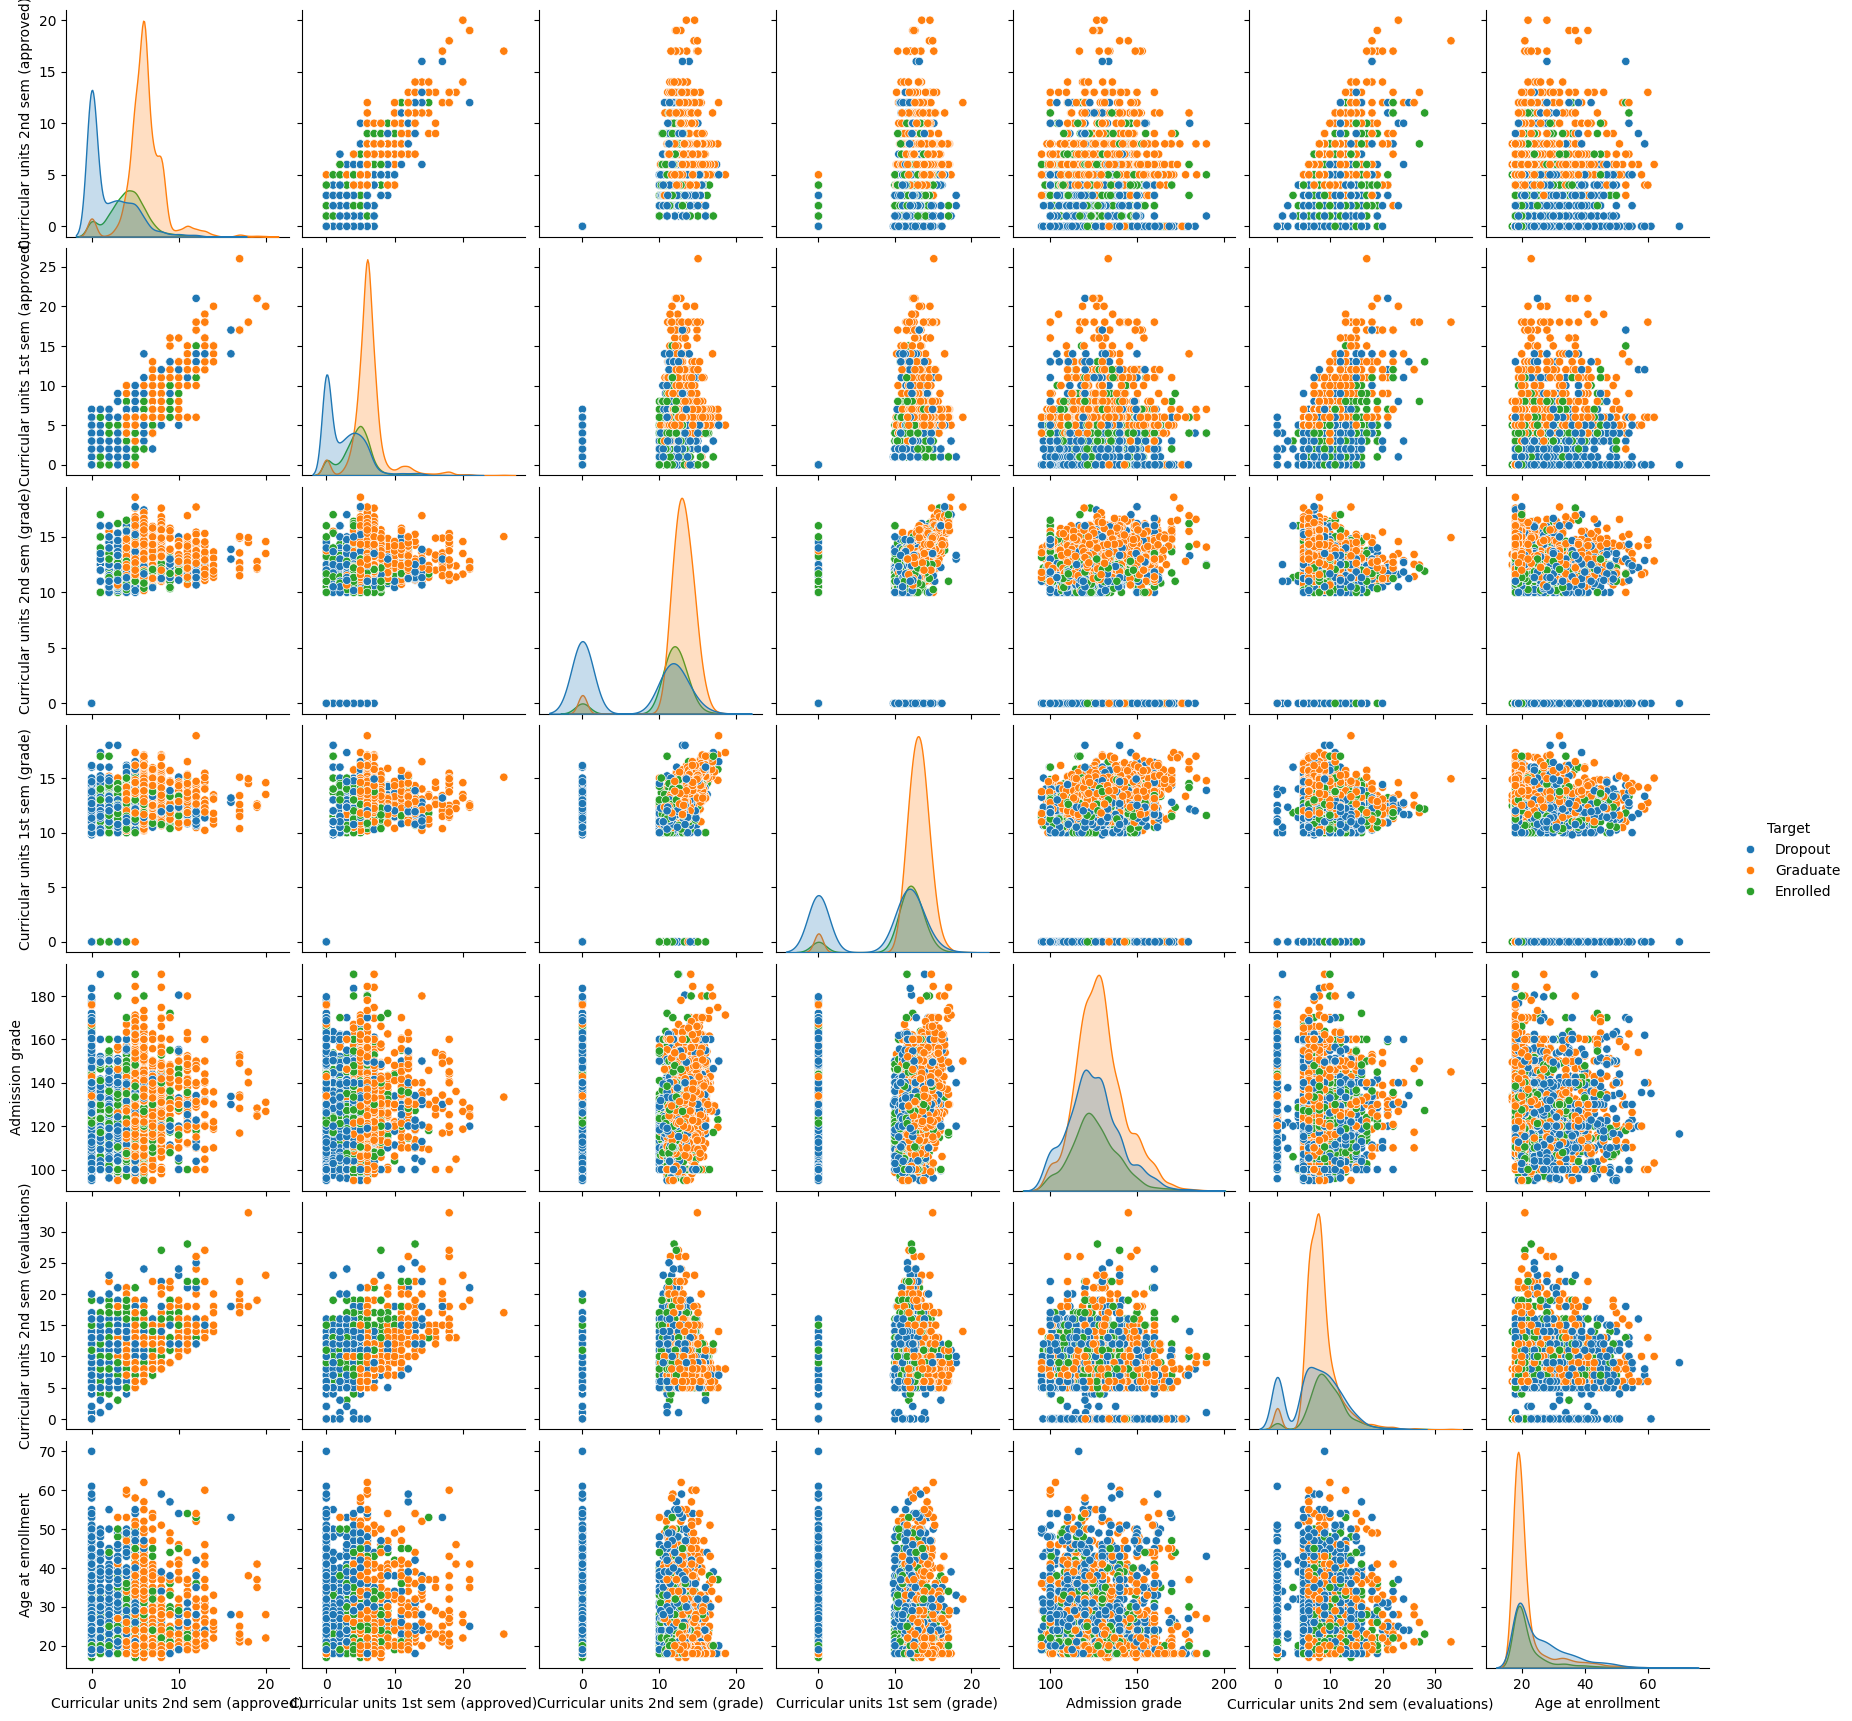

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df_pairplot = pd.concat([X_new, y], axis=1)

sns.pairplot(df_pairplot, hue='Target')

plt.show()

In [19]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['Target'])

print(label_encoder.classes_)  # ['Dropout', 'Enrolled', 'Graduate']

['Dropout' 'Enrolled' 'Graduate']


# Linear SVM

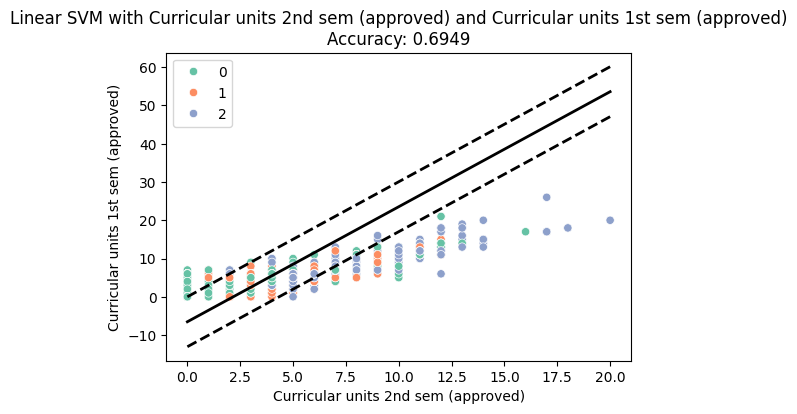

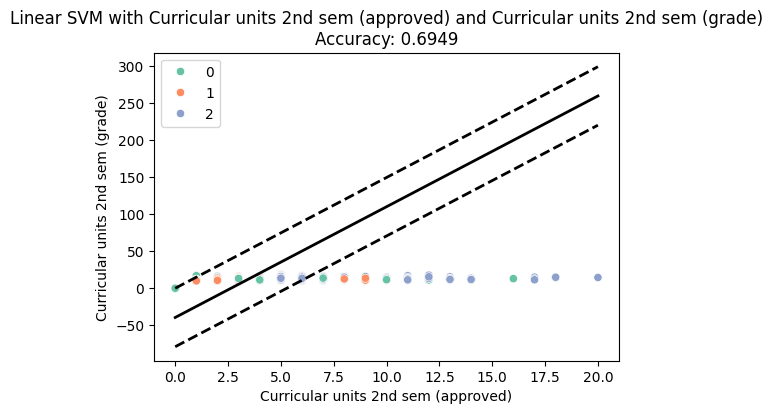

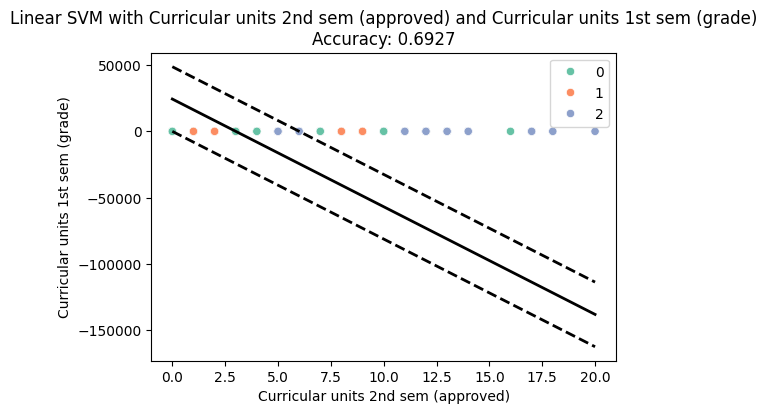

In [20]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import itertools
from joblib import Parallel, delayed

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

def train_linear_svm(X, y, feature_1, feature_2):
    X_subset = X[[feature_1, feature_2]]  # .values는 제거
    X_train, X_val, y_train, y_val = train_test_split(X_subset, y, test_size=0.2, random_state=42)
    svm_clf = SVC(kernel="linear", decision_function_shape="ovr")
    svm_clf.fit(X_train, y_train)
    y_pred = svm_clf.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy, svm_clf, X_train, y_train

def parallel_svm(feature_1, feature_2):
    return train_linear_svm(X_new, y_encoded, feature_1, feature_2)

feature_combinations = list(itertools.combinations(X_new.columns, 2))  # 조합 리스트로 변환
results = Parallel(n_jobs=-1)(delayed(parallel_svm)(f1, f2) for f1, f2 in feature_combinations)

accuracies = [(res[0], feature_combinations[i][0], feature_combinations[i][1], res[1], res[2], res[3]) for i, res in enumerate(results)]
top_3_linear = sorted(accuracies, key=lambda x: -x[0])[:3]

for acc, feature_1, feature_2, svm_clf, X_train, y_train in top_3_linear:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=X_train.iloc[:, 0], y=X_train.iloc[:, 1], hue=y_train, palette="Set2")
    plot_svc_decision_boundary(svm_clf, X_train.iloc[:, 0].min(), X_train.iloc[:, 0].max())
    plt.title(f"Linear SVM with {feature_1} and {feature_2}\nAccuracy: {acc:.4f}")
    plt.xlabel(feature_1)
    plt.ylabel(feature_2)
    plt.show()


# Soft Margin

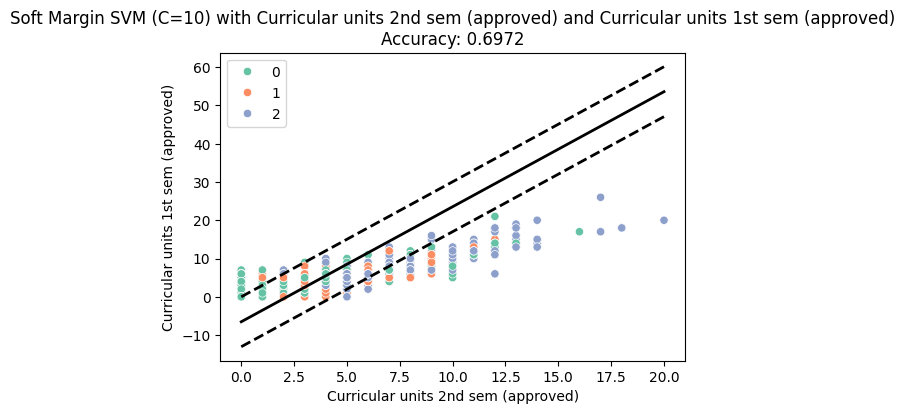

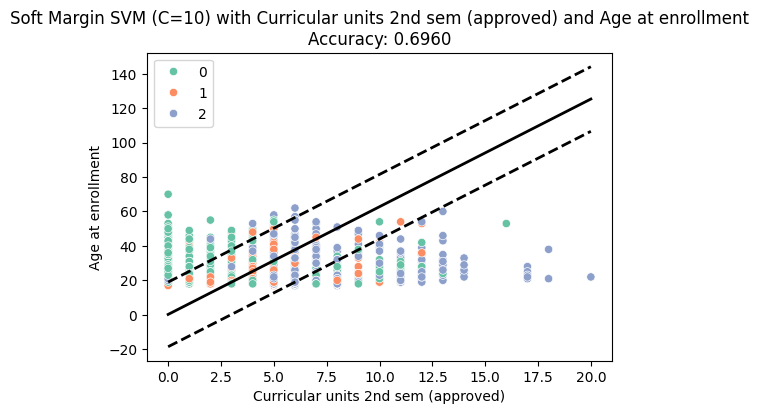

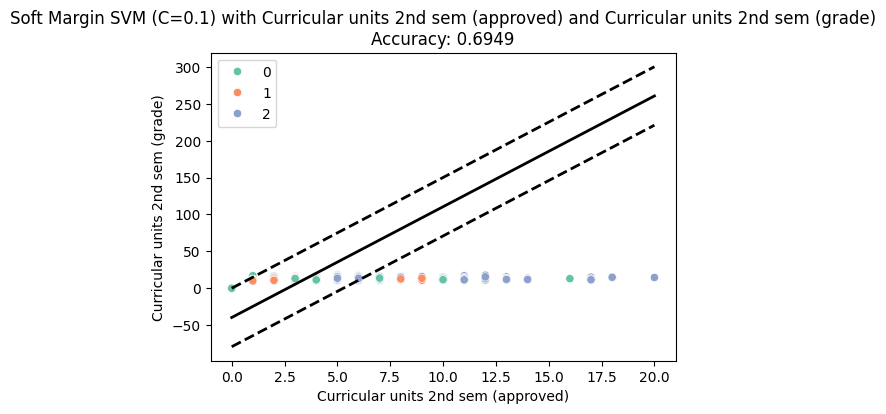

In [21]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns

def train_soft_margin_svm(X, y, feature_1, feature_2, C_values):
    X_subset = X[[feature_1, feature_2]].values
    X_train, X_val, y_train, y_val = train_test_split(X_subset, y, test_size=0.2, random_state=42)

    param_grid = {'C': C_values}
    svm_clf = SVC(kernel="linear", decision_function_shape="ovr")
    grid_search = GridSearchCV(svm_clf, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_svm_clf = grid_search.best_estimator_
    y_pred = best_svm_clf.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)

    return accuracy, best_svm_clf, X_train, y_train

def train_and_evaluate(feature_1, feature_2, C):
    accuracy, svm_clf, X_train, y_train = train_soft_margin_svm(X_new, y_encoded, feature_1, feature_2, [C])
    return accuracy, feature_1, feature_2, C, svm_clf, X_train, y_train

C_values = [0.1, 1, 10]
accuracies_soft_margin = []

for C in C_values:
    feature_combinations = itertools.combinations(X_new.columns, 2)

    results = Parallel(n_jobs=-1)(delayed(train_and_evaluate)(f1, f2, C) for f1, f2 in feature_combinations)
    accuracies_soft_margin.extend(results)

top_3_soft_margin = sorted(accuracies_soft_margin, key=lambda x: -x[0])[:3]

for acc, feature_1, feature_2, C, svm_clf, X_train, y_train in top_3_soft_margin:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=y_train, palette="Set2")

    plot_svc_decision_boundary(svm_clf, X_train[:, 0].min(), X_train[:, 0].max())

    plt.title(f"Soft Margin SVM (C={C}) with {feature_1} and {feature_2}\nAccuracy: {acc:.4f}")
    plt.xlabel(feature_1)
    plt.ylabel(feature_2)
    plt.show()


# Multiclass SVM Classifer

In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("data.csv", delimiter=';')
X = df.drop(columns=['Target'])
y = df['Target']

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

def train_and_plot_ovr(X_train, y_train, X_val, y_val):
    svm_clf_ovr = SVC(kernel="linear", decision_function_shape="ovr", n_jobs=-1)  # 병렬화
    svm_clf_ovr.fit(X_train, y_train)

    y_pred_ovr = svm_clf_ovr.predict(X_val)
    accuracy_ovr = accuracy_score(y_val, y_pred_ovr)
    print(f"OvR Accuracy: {accuracy_ovr:.4f}")

    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=y_train, palette="Set2")
    plot_svc_decision_boundary(svm_clf_ovr, X_train[:, 0].min(), X_train[:, 0].max())
    plt.title(f"One-vs-Rest (OvR) SVM")
    plt.show()

def train_and_plot_ovo(X_train, y_train, X_val, y_val):
    svm_clf_ovo = SVC(kernel="linear", decision_function_shape="ovo", n_jobs=-1)  # 병렬화
    svm_clf_ovo.fit(X_train, y_train)

    y_pred_ovo = svm_clf_ovo.predict(X_val)
    accuracy_ovo = accuracy_score(y_val, y_pred_ovo)
    print(f"OvO Accuracy: {accuracy_ovo:.4f}")

    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=y_train, palette="Set2")
    plot_svc_decision_boundary(svm_clf_ovo, X_train[:, 0].min(), X_train[:, 0].max())
    plt.title(f"One-vs-One (OvO) SVM")
    plt.show()

def svm_grid_search(X_train, y_train):
    param_grid = {
        'C': [0.1, 1, 10],
        'gamma': [0.001, 0.01, 0.1],
        'kernel': ['linear', 'rbf'],
        'decision_function_shape': ['ovr', 'ovo']
    }
    grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    return grid_search.best_estimator_

best_svm_model = svm_grid_search(X_train, y_train)

y_pred_best = best_svm_model.predict(X_val)
best_accuracy = accuracy_score(y_val, y_pred_best)
print(f"Best SVM Model Accuracy: {best_accuracy:.4f}")


Best parameters: {'C': 0.1, 'decision_function_shape': 'ovr', 'gamma': 0.001, 'kernel': 'linear'}
Best cross-validation score: 0.7624
Best SVM Model Accuracy: 0.7345
